# 모델 훈련

## 선형 회귀
비선형 회귀 모델은 파라미터가 많아서 과적합 되기 쉽다.

RMSE 를 성능 측정 지표로 자주 사용

### 정규방정식
비용함수를 최소화하는 theta값을 찾기 위한 수식

In [1]:
import numpy as np
X = 2*np.random.rand(100,1)
y = 4+3*X+np.random.randn(100,1)

In [2]:
X_b = np.c_[np.ones((100,1)),X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [3]:
theta_best

array([[3.48660191],
       [3.43112447]])

In [4]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)),X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.48660191],
       [10.34885086]])

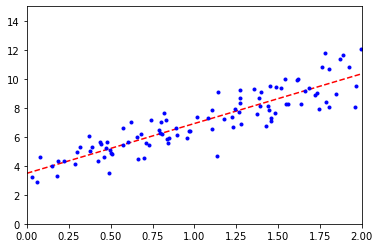

In [7]:
import matplotlib.pyplot as plt
plt.plot(X_new, y_predict,'r--')
plt.plot(X,y,'b.')
plt.axis([0,2,0,15])
plt.show()

In [8]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
print(lin_reg.intercept_, lin_reg.coef_)
print(lin_reg.predict(X_new))

[3.48660191] [[3.43112447]]
[[ 3.48660191]
 [10.34885086]]


LinearRegression 클래스는 np.linalg.lstsq() -> 최소 제곱 를 기반으로 한다.

In [10]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
print(theta_best_svd)

[[3.48660191]
 [3.43112447]]


유사역행렬 -> np.linalg.pinv()

In [12]:
np.linalg.pinv(X_b).dot(y)

array([[3.48660191],
       [3.43112447]])

### 계산 복잡도
정규방정식보다 SVD(특이값 분해)를 사용하는 것이 시간복잡도가 더 낮다.

## 경사 하강법 (GD)

In [13]:
eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta -= eta * gradients

In [14]:
theta

array([[3.48660191],
       [3.43112447]])

### 확률적 경사 하강법

In [15]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t+t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2*xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta -= eta * gradients

In [16]:
theta

array([[3.51542032],
       [3.41337087]])

In [21]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [22]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.44607106]), array([3.45151863]))

## 다항 회귀

In [34]:
m = 100
X = 6 * np.random.randn(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

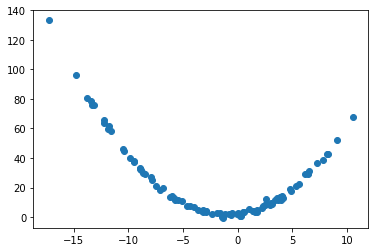

In [35]:
plt.scatter(X,y)

In [36]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])

[2.62128754]
[2.62128754 6.87114839]


In [37]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.92736328]), array([[0.99037129, 0.49767554]]))

## 학습 곡선

In [38]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m],y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors),"r-+",linewidth=2,label="훈련 세트")
    plt.plot(np.sqrt(val_errors),"b-",linewidth=3,label="검증 세트")
        

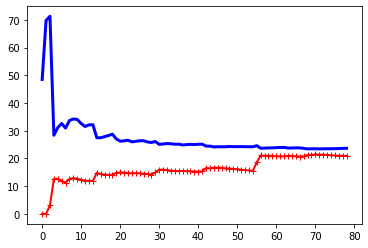

In [39]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg,X,y)

#### 10차 다항 회귀 모델의 학습곡선

(0.0, 3.0)

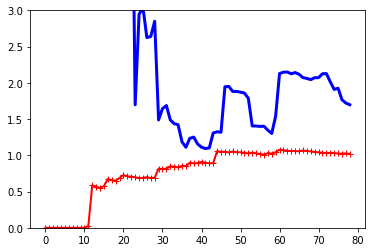

In [41]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg",LinearRegression()),
])

plot_learning_curves(polynomial_regression,X,y)
plt.ylim([0,3])

### 편향/분산 트레이드오프
일반화 오차를 세 가지 다른 종류의 오차의 합으로 표현
* 편향 : 일반화 오차 중에서 편향은 잘못된 가정으로 인한 것 ( 편향이 큰 모델은 과소적합되기 쉽다. )
* 분산 : 훈련 데이터에 있는 작은 변동에 모델이 과도하게 민감하기 때문에 나타난다.
* 줄일 수 없는 오차 : 데이터 자체에 있는 잡음 때문에 발생

## 규제가 있는 선형 모델
자유도를 줄이면 과대적합되기 더 힘들어진다.

훈련에 사용되는 비용함수는 미분가능해야 하는 반면에 테스트에 사용되는 성능지표는 최종 목표에 가능한 한 가까워야 한다.

### 릿지 회귀
L2 norm
입력 특성의 스케일에 민감하기 때문에 수행하기 전에 데이터 스케일을 맞추는 것이 중요(e.g StandardScaler)

In [44]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[15.14748064]])

확률적 경사 하강법에 사용

In [43]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

array([13.79156599])

### 라쏘 회귀
l1 norm
theta(i)= 0일때 미분 가능하지 않아서 서브그레이디언트 벡터  g를 사용하여 경사 하강법을 적용시킨다.

In [46]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([15.15428679])

이것도 SGDRegressor(penalty="l1")가능

### 엘라스틱넷
릿지 라쏘 절충
r = 0이면 릿지회귀와 같고
r = 1이면 라쏘회귀와 같다

In [49]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([15.15840534])

### 조기 종료

In [55]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
# 데이터 준비
X_train, X_val, y_train, y_val = train_test_split(X,y)

poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                      penalty=None, learning_rate="constant",eta0=0.0005)
minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel())
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

warm_start = True -> fit()메서드가 호출될 때 처음부터 다시 시작하지 않고 이전 모델 파라미터에서 훈련을 이어나간다.

## 로지스틱 회귀
분류에 사용되는 회귀 알고리즘

 ### 확률 추정
 마지막 로지스틱 함수

### 결정 경계

In [57]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [58]:
X = iris['data'][:,3:] # 꽃잎의 너비
y = (iris['target'] == 2).astype(np.int) # Iris-Virginica면 1 아니면 0

In [60]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression()

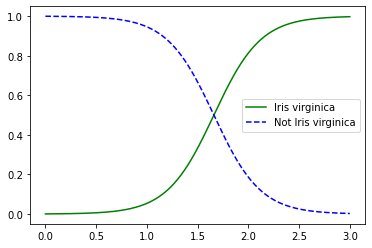

In [62]:
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1],"g-",label="Iris virginica")
plt.plot(X_new, y_proba[:,0],"b--",label="Not Iris virginica")
plt.legend()

결정경계 대락 1.6

In [63]:
log_reg.predict([[1.7],[1.5]])

array([1, 0])

* 사이킷런의 Logistice Regression 모델의 규제 강도를 조절하는 하이퍼파라미터는 다른 선형모델처럼 alpha가 아니라 그 역수 C이다. C가 높을수록 모델의 규제가 줄어든다.

### 소프트맥스 회귀
= 다항 로지스틱 회귀 ( 로지스틱 회귀 모델에서 여러 개의 이진 분류기를 연결하지 않고 직접 다중 클래스를 지원하도록 일반화한 것 )

크로스 엔트로피
- 쿨백-라이블러 발산이라 불리는 양만큼 커질 것이다.

In [64]:
X = iris["data"][:,(2,3)] # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs",C=10)
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial')

In [65]:
softmax_reg.predict([[5,2]]) # 꽆잎의 길이가 5, 너비가 2인 붓꽃은...?

array([2])

In [66]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

소프트맥스 회귀는 가장 높은 확률의 클래스를 선정한다.